### 重点分析泰坦尼克号沉船事故，探索是什么因素决定了最后是否生还。

新增知识点：
- 缺失值处理：pandas中的fillna()方法
- 数据透视表：pandas中的pivot_table函数
- seaborn可视化熟练：sns.FacetGrid().map()
- 连续变量离散化：pd.cut(), pd.qcut()  titanic["Ageband"]=pd.cut(titanic["Age"],5)

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
titanic=pd.read_csv('titanic.csv',sep=';')

In [14]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 字段说明
- PassengerId: 乘客的id
- Survival: 是否幸存 0 = No, 1 = Yes
- Pclass: 舱位 class 1 = 1st, 2 = 2nd, 3 = 3rd
- Name: 姓名
- Sex: 性别
- Age: 年龄
- SibSp: 船上兄弟姐妹以及配偶的个数
- Parch: 船上父母以及子女的个数
- Ticket: 船票号码
- Fare: 票价
- Cabin: 船舱号码
- Embarked: 登船码头 C = Cherbourg, Q = Queenstown, S = Southampton

## 泰坦尼克号幸存者特征画像-分析框架
1. 一切的分析都建立在数据清洗之后
2. 幸存率的分析非常重要，下面将按性别、年龄、仓位、登船码头4个维度分别观察与幸存率的关系
3. 然后按照仓位+性别、仓位+年龄段、年龄段+性别3个二维组合维度观察与幸存率的关系
4. 最后按仓位+性别+年龄段这个三维组合维度观察与幸存率关系
5. 附加，船上兄弟姐妹配偶个数、父母子女个数，与幸存率的关系
6. 附加，船上兄弟姐妹配偶个数、父母子女个数，与仓位、登船码头的关系--拖家带口的乘客特征

### 数据清洗
1. .info()查看各字段非空值数量、类型等
2. 对于数值变量，describe查看各字段统计值、计数
3. 对于分类变量，describe(include=[np.object])查看各字段情况
4. 缺失值处理，不重要的字段直接删除
5. 缺失值处理，重要字段，先将字段分块，然后对各分块空值填充各分块的中位数
6. 缺失值处理，一般不直接删除有缺失值的行，因为其他字段可能有用

#### 观察数据

In [15]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [13]:
titanic[['Survived','Age','SibSp','Parch']].describe()

,Survived,Age,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594
std,0.486592,14.526497,1.102743,0.806057
min,0.000000,0.420000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,0.000000
75%,1.000000,38.000000,1.000000,0.000000
max,1.000000,80.000000,8.000000,6.000000


In [18]:
# 使用include=[np.object]来查看分类变量
# count: 非缺失值的个数
# unique: 非重复值得个数
# top: 最高频值
# freq: 最高频值出现次数
titanic.describe(include=[np.object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mitkoff, Mr. Mito",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


- Age字段很重要，有20%内的缺失值，考虑用分段中位数补全
- Cabin字段缺失值较多，且不重要，因此直接删除此字段
- 男性有577人，有644人在S码头登船

#### 补全数据
- Age字段很重要，有20%内的缺失值，考虑用分段中位数补全

In [26]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [15]:
"""直接用整体Age中位数补全年龄空值"""

# 计算Age字段中位数，series.fillna()补全空值
age_median1=titanic.Age.median()
titanic.Age.fillna(age_median1,inplace=True)
titanic.Age.describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [16]:
"""考虑性别因素，补全年龄空值"""

#再次读取原始数据
titanic=pd.read_csv('titanic.csv',sep=';')

# age_median2=titanic.groupby("Sex").agg({"Age":["median"]})
#.agg语句与下面语句实现相同效果
age_median2=titanic.groupby("Sex").Age.median()

# 要按性别中位数补全空值，先将Age设置为索引，使用结束后用reset_index重置索引
titanic.set_index("Sex",inplace=True)

# 使用fillna补全空值，将根据索引进行补全
titanic.Age.fillna(age_median2,inplace=True)

# 重置索引
titanic.reset_index(inplace=True)

titanic.Age.describe()

count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [139]:
"""考虑仓位+性别补全年龄空值"""

#再次读取原始数据
titanic=pd.read_csv('/Users/dengsudden/Documents/python_course/titanic.csv',sep=';')

# 分组计算不同仓位、性别的年龄中位数，得到一个Series数据，索引为Pclass、Sex
age_median3=titanic.groupby(["Pclass","Sex"]).Age.median()

titanic.set_index(["Pclass","Sex"],inplace=True)

titanic.Age.fillna(age_median3,inplace=True)

titanic.reset_index(inplace=True)

titanic.Age.describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

- 至此，数据集的Age字段按照仓位+性别中位数被补全

### 生还率关联因素分析
- 按性别、年龄段、仓位、登船码头4个维度分别观察与幸存率的关系
- 按照仓位+性别、仓位+年龄段、年龄段+性别3个二维组合维度观察与幸存率的关系
- 按仓位+性别+年龄段这个三维组合维度观察与幸存率关系

#### 仓位比例、性别比例、登船码头比例

In [43]:
# 仓位比例
titanic.Pclass.value_counts()/len(titanic)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [45]:
# 性别比例
titanic.Sex.value_counts()/len(titanic)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [46]:
# 登船码头比例
titanic.Embarked.value_counts()/len(titanic)

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

### 按性别、年龄、仓位、登船码头4个维度分别观察与幸存率的关系

#### 各仓位幸存率

In [49]:
"""groupby方法"""

# Survived字段表示 0 1 幸存状态，均值正好就是幸存率
titanic[["Pclass","Survived"]].groupby("Pclass").mean()\
.sort_values(by="Survived",ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [51]:
"""数据透视表"""

# values: aggfunc函数作用对象
# index: 分组用的变量
# aggfunc: 作用函数
titanic.pivot_table(values="Survived",index="Pclass",aggfunc="mean")

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


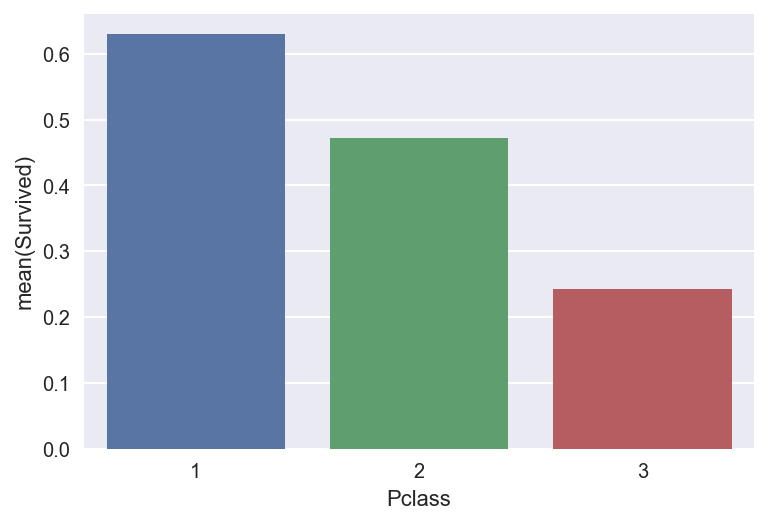

In [53]:
sns.barplot(data=titanic,x="Pclass",y="Survived",ci=None)

#### 各性别幸存率

In [54]:
titanic.pivot_table(values="Survived",index="Sex",aggfunc="mean")

,Survived
Sex,
female,0.742038
male,0.188908


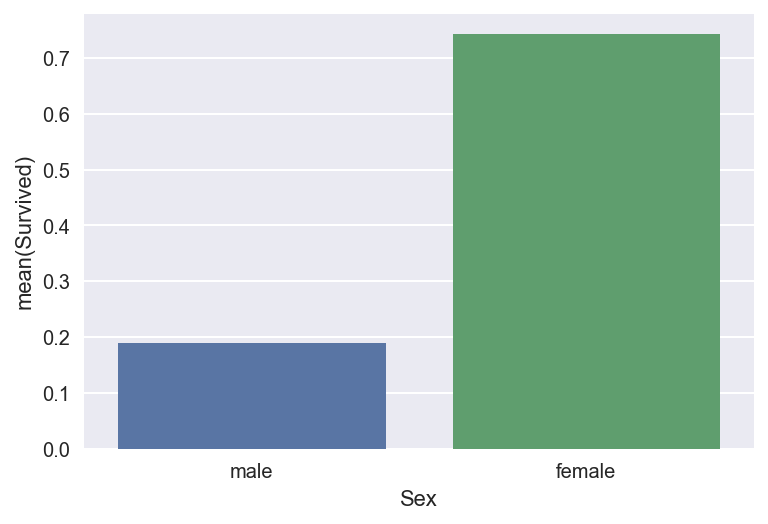

In [55]:
sns.barplot(data=titanic,x="Sex",y="Survived",ci=None)

#### 年龄与幸存率
- 年龄是连续变量，不能像分类变量那样直接进行统计
- 可以用直方图展示
- 后续会将连续变量离散化处理（分段赋值，类似于成绩ABCD）

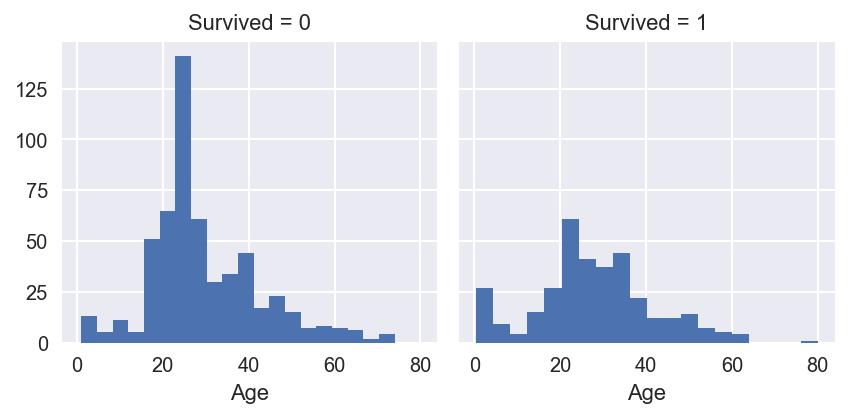

In [67]:
# FacetGrid中的col参数，让sns在画布的一行中绘制出各col变量的图
# FaceGtrid中的row参数，让sns在画布的一列中绘制出各row变量的图

sns.FacetGrid(titanic,col="Survived").map(plt.hist,"Age",bins=20)

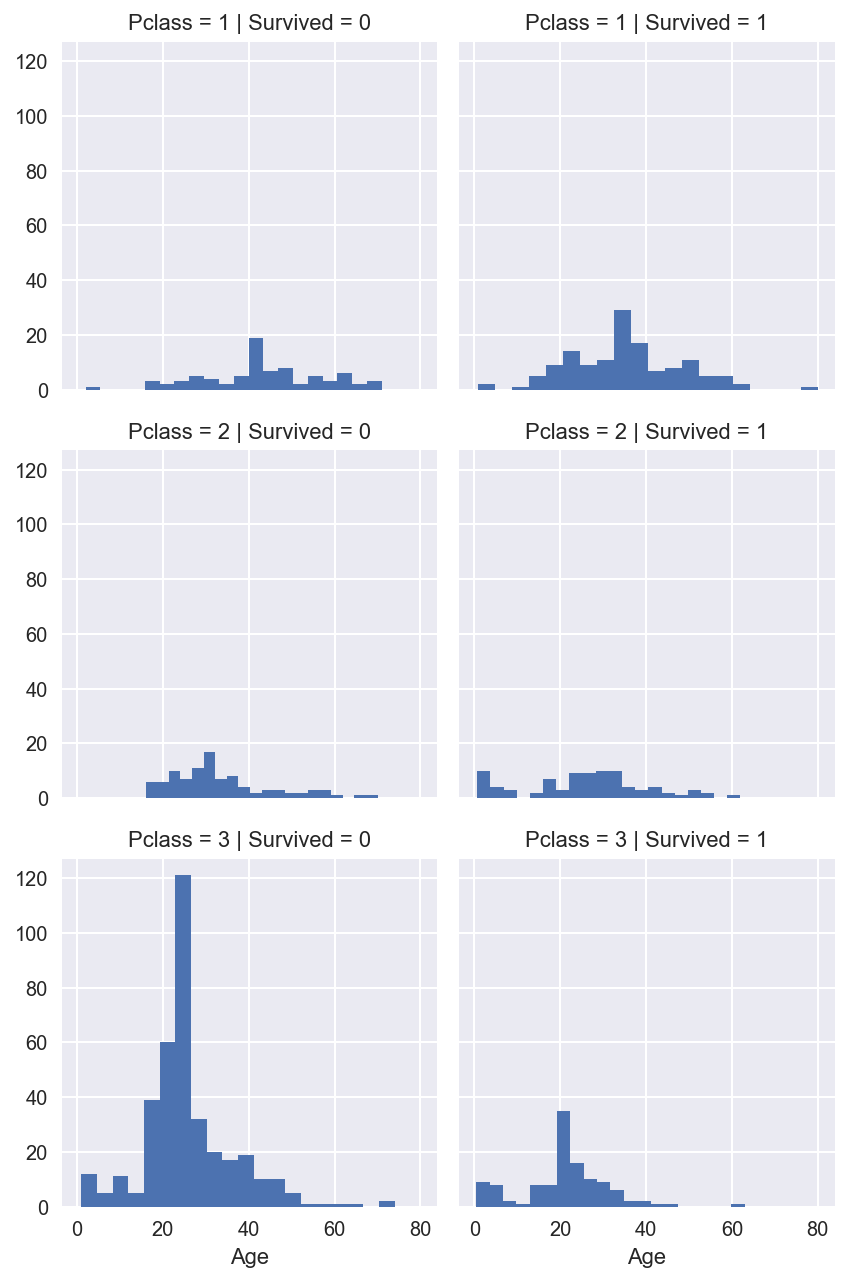

In [68]:
# 考虑舱位因素后，绘制生还组和罹难组的年龄分布直方图 
# 提示：FacetGrid参数中同时设置col和row

sns.FacetGrid(titanic,col="Survived",row="Pclass")\
.map(plt.hist,"Age",bins=20)

#### 各登船码头幸存率

In [56]:
titanic[["Embarked","Survived"]].groupby("Embarked").mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


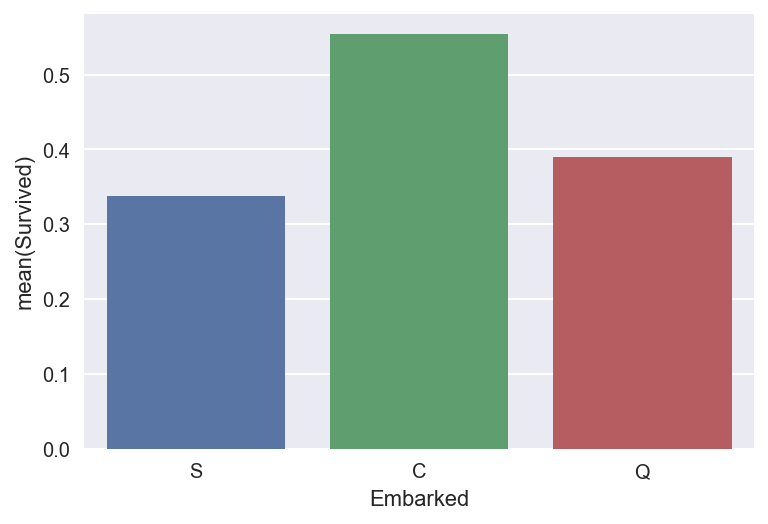

In [57]:
sns.barplot(data=titanic,x="Embarked",y="Survived",ci=None)

- C码头登船的幸存率较高，为什么呢？
- 看看各码头登船的仓位情况

In [58]:
titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [60]:
titanic.pivot_table(values="Name",index="Pclass",columns="Embarked",aggfunc="count")

Embarked,C,Q,S
Pclass,,,
1,85,2,127
2,17,3,164
3,66,72,353


- S码头登船人数最多，大部分是3等仓位
- Q码头登船的人90%以上是3等仓位
- C码头登船的人半数是1等仓位，数据来看1等仓位的幸存率较高，因此C码头登船的人幸存率较高可解释
> 看来C码头主要是有钱人登船，S码头就主要是穷人了

### 按照仓位+性别、仓位+年龄段、年龄段+性别3个二维组合维度观察与幸存率的关系

#### 仓位+性别

In [66]:
titanic.pivot_table(values="Survived",index="Pclass",columns="Sex",aggfunc="mean")

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


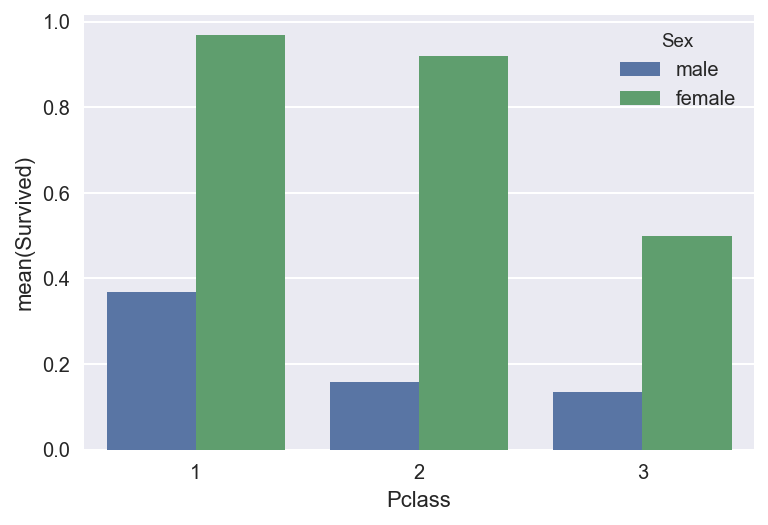

In [63]:
sns.barplot(data=titanic,x="Pclass",y="Survived",hue="Sex",ci=None)

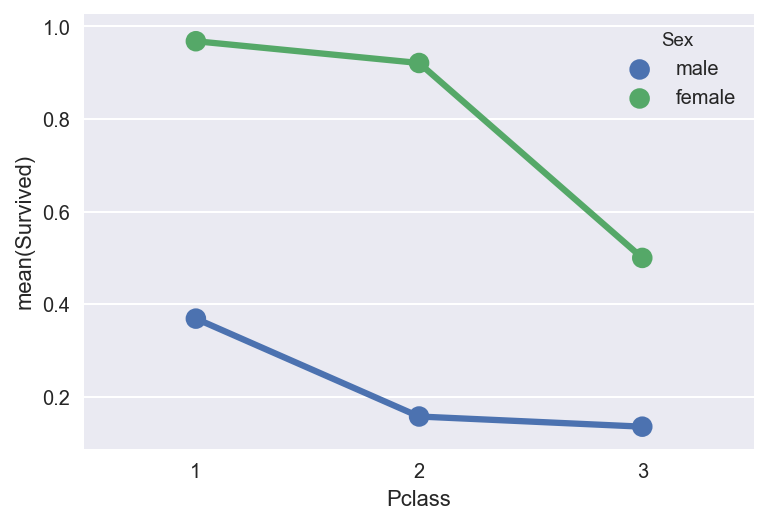

In [64]:
sns.pointplot(data=titanic,x="Pclass",y="Survived",hue="Sex",ci=None)

- 男性幸存率普遍低于女性，这难道是传说中的绅士风度在起作用？
- 高等仓位幸存率高于低等仓位，一方面可能是因为高等仓位在上层，淹水较慢，逃生时间够长，另一方面可能是人为因素，高等仓位更受照顾
- 一二等仓的女性幸存率很高啊，二三等仓的男性幸存率极低

### 连续变量离散化
- 连续型变量离散化是建模中一种常用的方法
- 离散化指的是将某个变量的所在区间分割为几个小区间，落在同一个区间的观测值用同一个符号表示
- 以年龄为例，最小值是0.42（婴儿），最大值是80，如果我们想产生一个五个级（levels），我们可使用cut或者qcut函数
- cut函数将年龄的区间均匀分割为5份
- qcut则选取区间以至于每个区间里的观察值个数都是一样的（五等分）

In [80]:
titanic["Ageband"]=pd.cut(titanic["Age"],5)
titanic.head()

,Pclass,Sex,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ageband
0,3,male,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,"(16.336, 32.252]"
1,1,female,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,"(32.252, 48.168]"
2,3,female,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(16.336, 32.252]"
3,1,female,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,"(32.252, 48.168]"
4,3,male,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,"(32.252, 48.168]"


In [82]:
titanic.Ageband.value_counts(sort=False)

(0.34, 16.336]      100
(16.336, 32.252]    493
(32.252, 48.168]    218
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Ageband, dtype: int64

#### 年龄段+性别

In [85]:
titanic.pivot_table(values="Survived",index="Ageband",columns="Sex",aggfunc="mean")

Sex,female,male
Ageband,,
"(0.34, 16.336]",0.673469,0.431373
"(16.336, 32.252]",0.701220,0.155015
"(32.252, 48.168]",0.818182,0.191489
"(48.168, 64.084]",0.916667,0.177778
"(64.084, 80.0]",NaN,0.090909


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

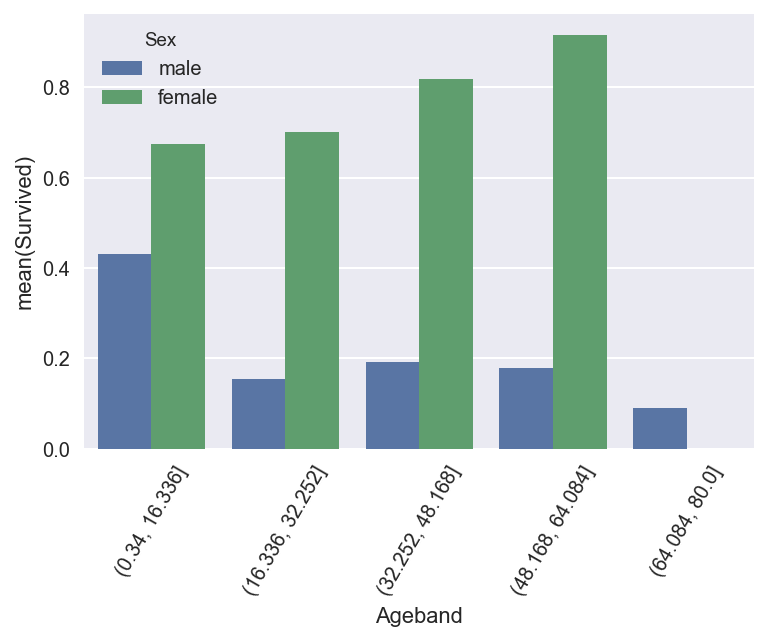

In [87]:
sns.barplot(data=titanic,x="Ageband",y="Survived",hue="Sex",ci=None)

# 设置横轴标签位置
plt.xticks(rotation=60)

- 男性生存率明显偏低与女性
- 女性高年龄段的生存率逐次高于低年龄段的

#### 年龄段与生存率

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

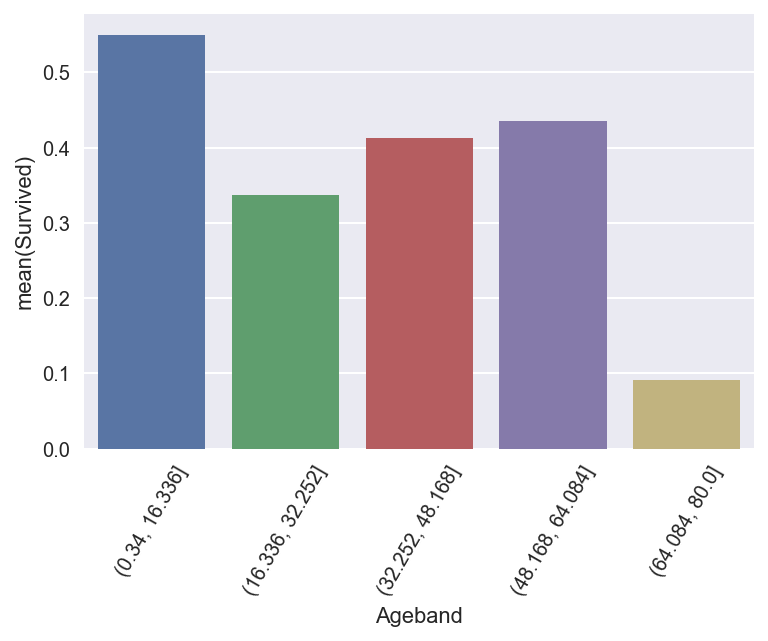

In [89]:
sns.barplot(data=titanic,x="Ageband",y="Survived",ci=None)
plt.xticks(rotation=60)

- 低年龄段生存率最高
- 64岁以上老人生存率最低，青壮年次之，看来大家还是很有爱的，小朋友先救，青壮年让位，老人可能体力不支或自动放弃

#### 仓位+年龄段

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

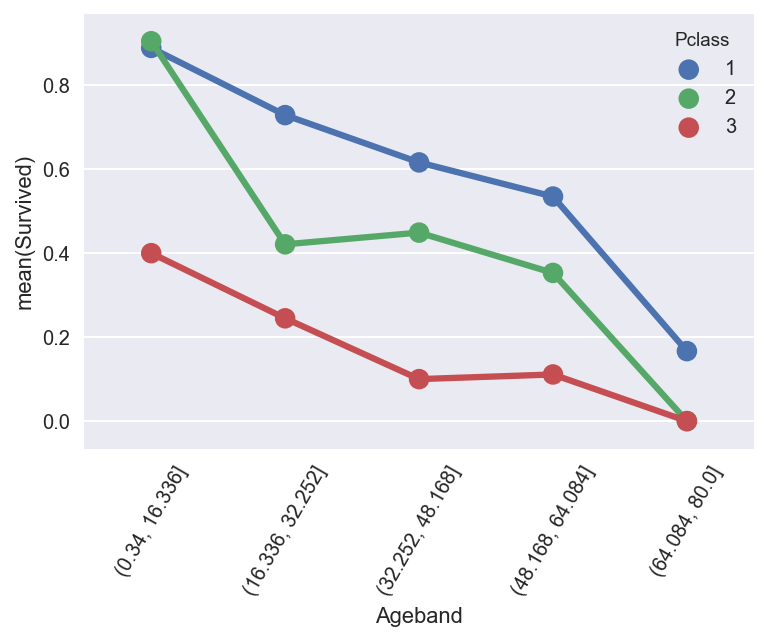

In [100]:
sns.pointplot(data=titanic,x="Ageband",y="Survived",hue="Pclass",ci=None)
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

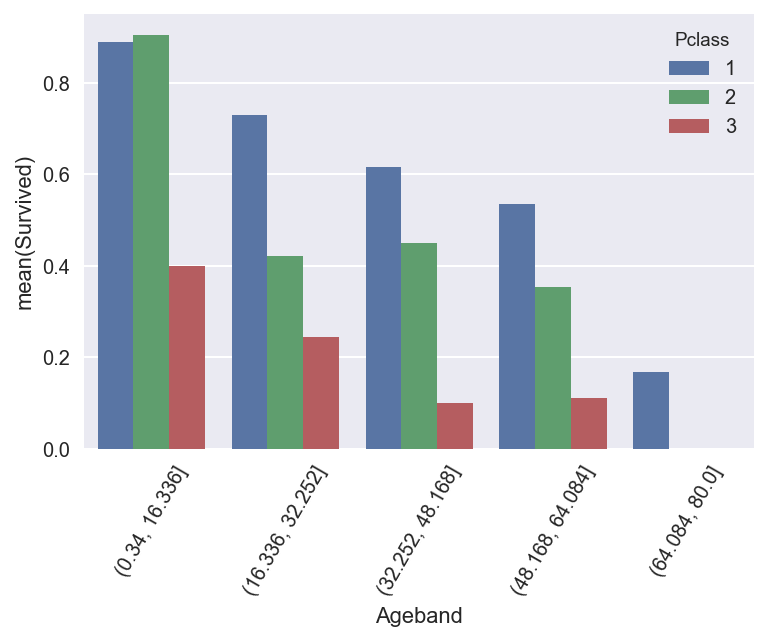

In [99]:
sns.barplot(data=titanic,x="Ageband",y="Survived",hue="Pclass",ci=None)
plt.xticks(rotation=60)

- 各年龄段1等仓位的生存率最高，3等仓位生存率最低
- 低年龄段的生存率逐次高于高年龄段
- 在考虑各分组生存率的同时，要考虑各分组人数，比如该分组并没有人，那么生存率自然是0，但我们并不能说该分组生存率最低

### 仓位+性别+年龄段，与幸存率关系

In [93]:
titanic.head()

,Pclass,Sex,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ageband
0,3,male,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,"(16.336, 32.252]"
1,1,female,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,"(32.252, 48.168]"
2,3,female,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(16.336, 32.252]"
3,1,female,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,"(32.252, 48.168]"
4,3,male,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,"(32.252, 48.168]"


- 数据形式呈现

In [94]:
titanic.pivot_table(values="Survived",index="Ageband",columns=["Sex","Pclass"],aggfunc="mean")

Sex                 female                          male                    
Pclass                   1         2         3         1         2         3
Ageband                                                                     
(0.34, 16.336]    0.833333  1.000000  0.545455  1.000000  0.818182  0.270270
(16.336, 32.252]  0.968750  0.921053  0.521277  0.444444  0.087719  0.138776
(32.252, 48.168]  1.000000  0.909091  0.250000  0.366667  0.074074  0.055556
(48.168, 64.084]  0.941176  0.833333  1.000000  0.269231  0.090909  0.000000
(64.084, 80.0]         NaN       NaN       NaN  0.166667  0.000000  0.000000

- 可视化呈现

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

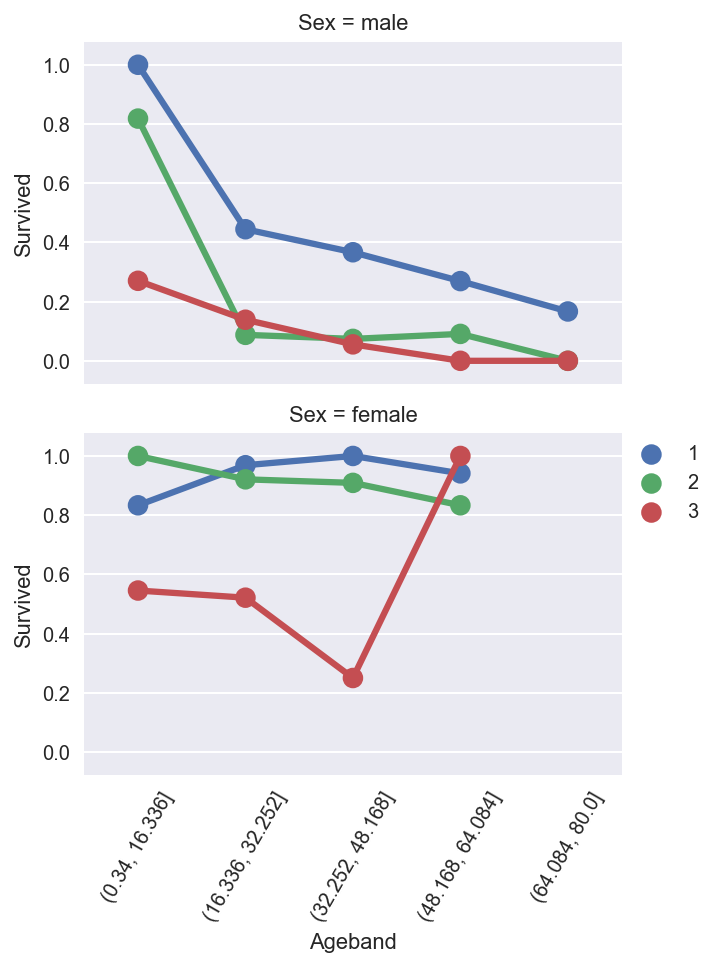

In [104]:
"""各性别下，仓位+年龄段与幸存率关系"""

# aspect设置画布长宽比
# palette设置hue分组的颜色
sns.FacetGrid(data=titanic,row="Sex",aspect=1.5)\
.map(sns.pointplot,"Ageband","Survived","Pclass",palette="deep",ci=None)\
.add_legend()

plt.xticks(rotation=60)

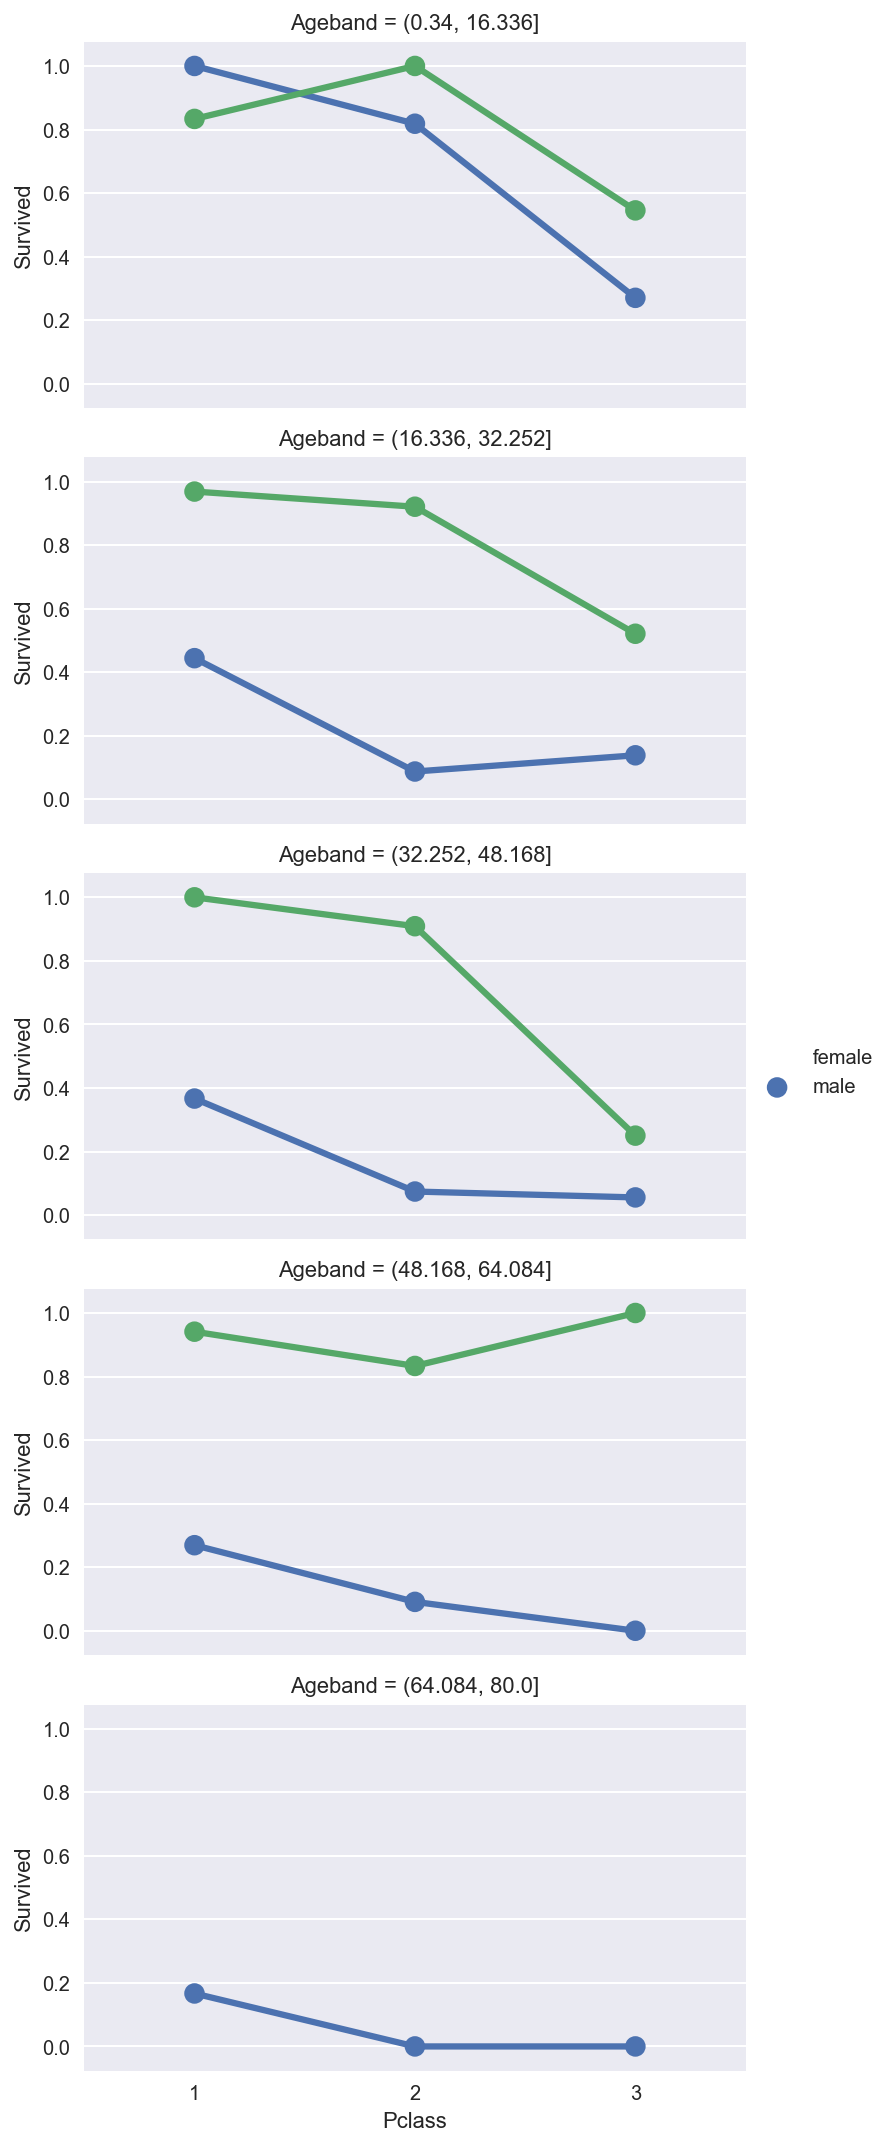

In [108]:
"""各年龄段下，仓位+性别的幸存率"""

sns.FacetGrid(data=titanic,row="Ageband",aspect=1.8)\
.map(sns.pointplot,"Pclass","Survived","Sex",hue_order=["male","female"],palette="deep",ci=None)\
.add_legend()

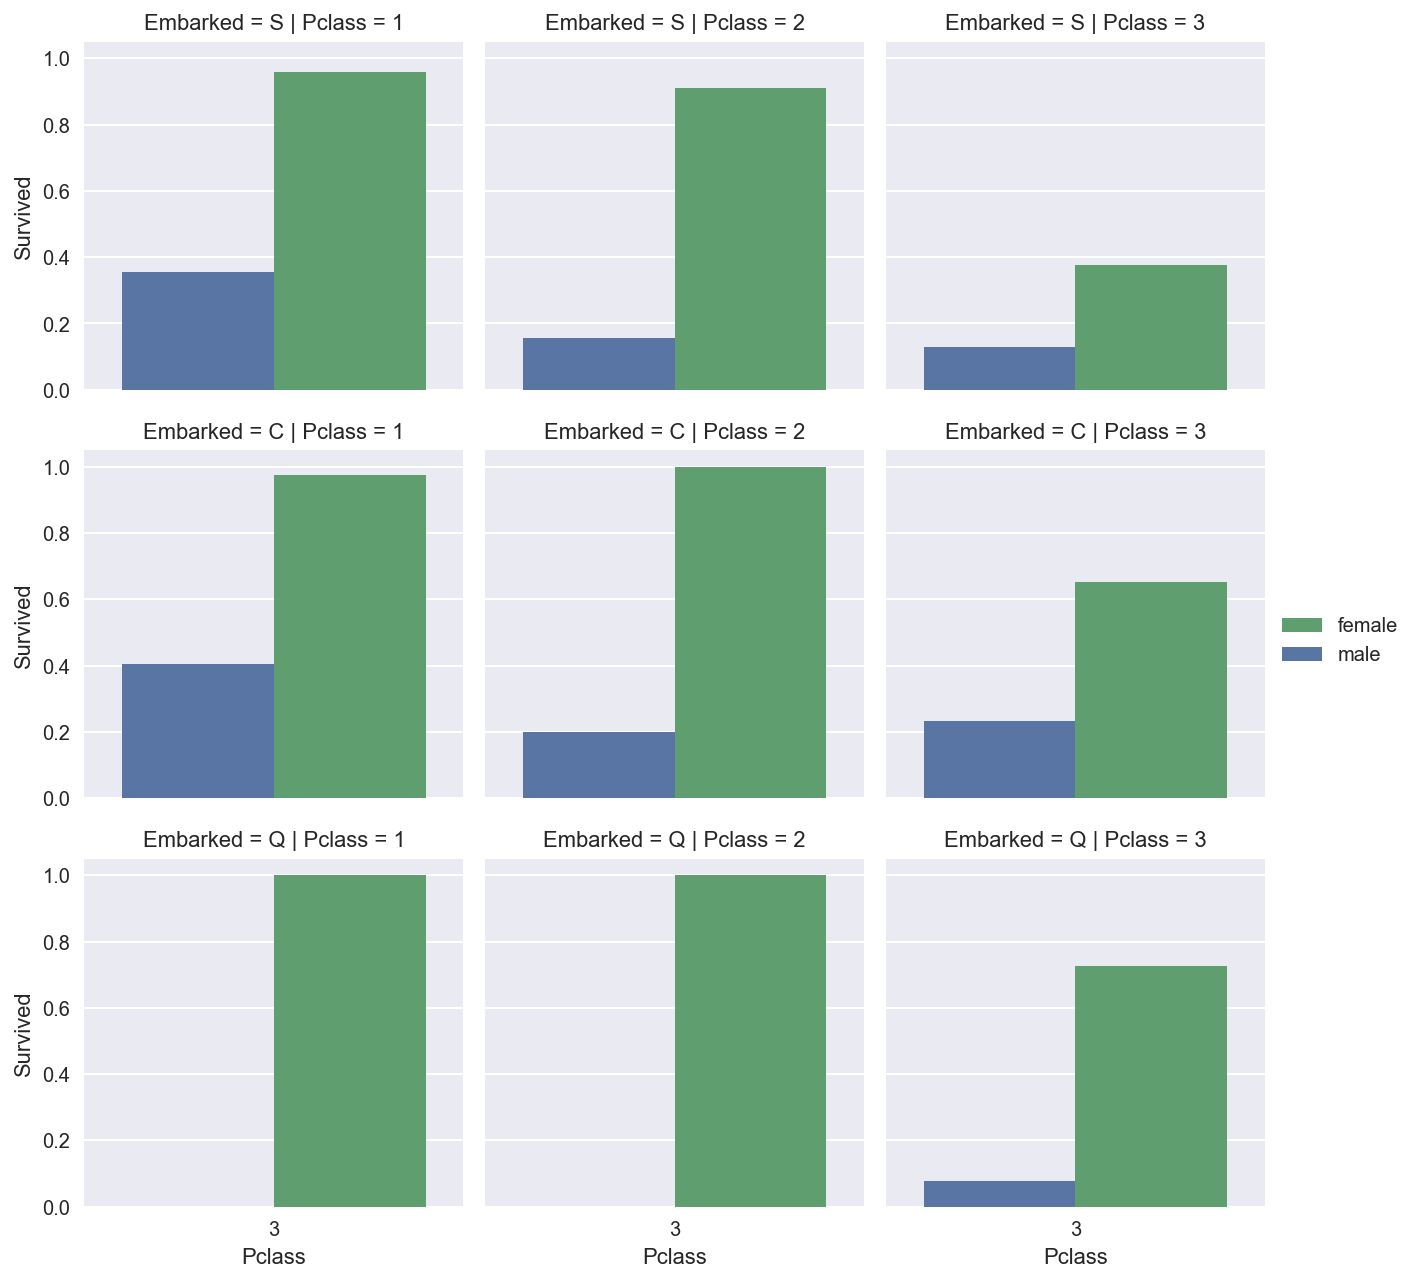

In [113]:
sns.FacetGrid(data=titanic,col="Pclass",row="Embarked")\
.map(sns.barplot,"Pclass","Survived","Sex",hue_order=["male","female"],palette="deep",ci=None)\
.add_legend()

In [115]:
titanic.pivot_table(values="Survived",index="Embarked",columns=["Pclass","Sex"],aggfunc="mean")

Pclass           1                   2                   3          
Sex         female      male    female      male    female      male
Embarked                                                            
C         0.976744  0.404762  1.000000  0.200000  0.652174  0.232558
Q         1.000000  0.000000  1.000000  0.000000  0.727273  0.076923
S         0.958333  0.354430  0.910448  0.154639  0.375000  0.128302

- 不论从登船码头还是仓位来看，女性幸存率普遍高于男性
- 按性别来看，高等仓位幸存率高于低等仓位
- Q码头登船的男乘客生存率最低，我们来看看是不是Q码头男乘客数量较少？

In [116]:
titanic.pivot_table(values="Survived",index="Embarked",columns="Sex",aggfunc="count")

Sex,female,male
Embarked,,
C,73,95
Q,36,41
S,203,441


- Q码头登船男乘客多于女乘客，但几乎都罹难了，为什么呢？我们来看看男乘客的仓位、年龄段分布情况，是不是这些情况导致了男乘客生存率较低

In [118]:
titanic.pivot_table(values="Survived",index="Embarked",columns=["Pclass","Sex","Ageband"],aggfunc="count")

Pclass                1                                                     \
Sex              female                                                      
Ageband  (0.34, 16.336] (16.336, 32.252] (32.252, 48.168] (48.168, 64.084]   
Embarked                                                                     
C                   1.0             16.0             17.0              9.0   
Q                   NaN              NaN              1.0              NaN   
S                   5.0             16.0             20.0              7.0   

Pclass                                                                      \
Sex                male                                                      
Ageband  (0.34, 16.336] (16.336, 32.252] (32.252, 48.168] (48.168, 64.084]   
Embarked                                                                     
C                   NaN             14.0             15.0             10.0   
Q                   NaN              NaN              1.0              NaN   
S                   3.0             13.0             44.0             16.0   

Pclass                               2      ...                       \
Sex                             female      ...                 male   
Ageband  (64.084, 80.0] (0.34, 16.336]      ...       (64.084, 80.0]   
Embarked                                    ...                        
C                   3.0            2.0      ...                  NaN   
Q                   NaN            NaN      ...                  NaN   
S                   3.0            8.0      ...                  2.0   

Pclass                3                                                     \
Sex              female                                                      
Ageband  (0.34, 16.336] (16.336, 32.252] (32.252, 48.168] (48.168, 64.084]   
Embarked                                                                     
C                  11.0             11.0              1.0              NaN   
Q                   3.0             29.0              1.0              NaN   
S                  19.0             54.0             14.0              1.0   

Pclass                                                                      \
Sex                male                                                      
Ageband  (0.34, 16.336] (16.336, 32.252] (32.252, 48.168] (48.168, 64.084]   
Embarked                                                                     
C                   4.0             33.0              6.0              NaN   
Q                   4.0             31.0              2.0              NaN   
S                  29.0            181.0             46.0              8.0   

Pclass                   
Sex                      
Ageband  (64.084, 80.0]  
Embarked                 
C                   NaN  
Q                   2.0  
S                   1.0  

[3 rows x 27 columns]

- Q码头登船的男乘客，绝大部分处于16-32岁，3等仓位，这个分段的乘客幸存率是最低的
- 解释了，为什么Q码头登船的男乘客幸存率趋于0的现象

### 附加
- 船上兄弟姐妹配偶个数、父母子女个数，与幸存率的关系
- 船上兄弟姐妹配偶个数、父母子女个数，与仓位、登船码头的关系--拖家带口的乘客特征

- SibSp: 船上兄弟姐妹以及配偶的个数
- Parch: 船上父母以及子女的个数

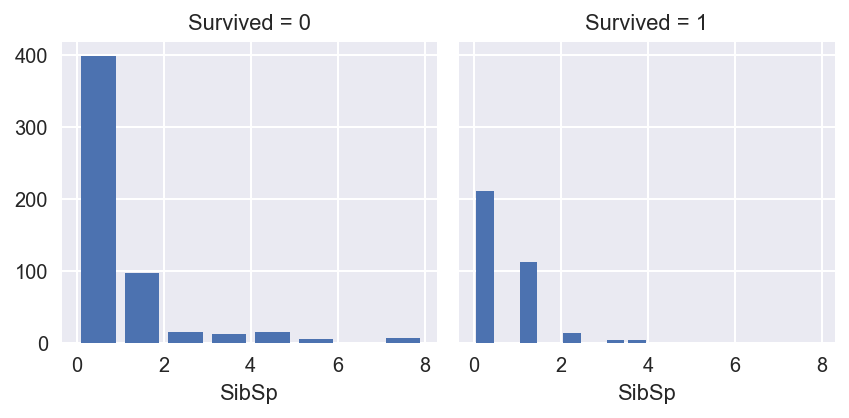

In [129]:
sns.FacetGrid(data=titanic,col="Survived")\
.map(plt.hist,"SibSp",bins=8,rwidth=0.8)

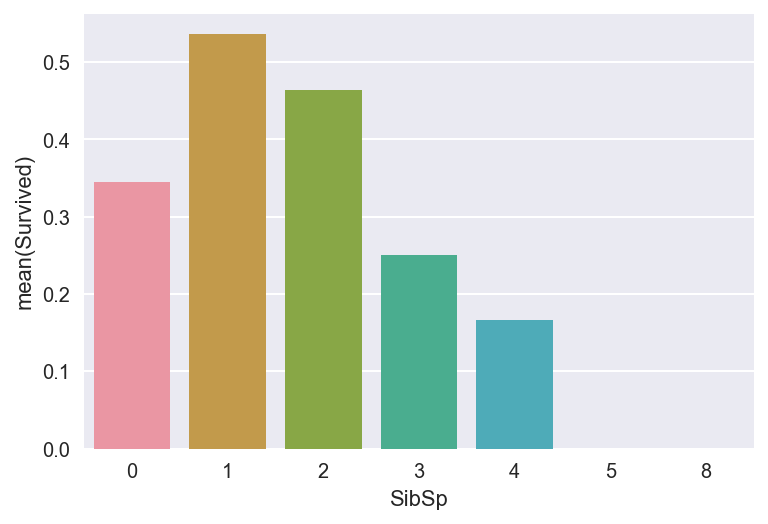

In [130]:
sns.barplot(data=titanic,x="SibSp",y="Survived",ci=None)

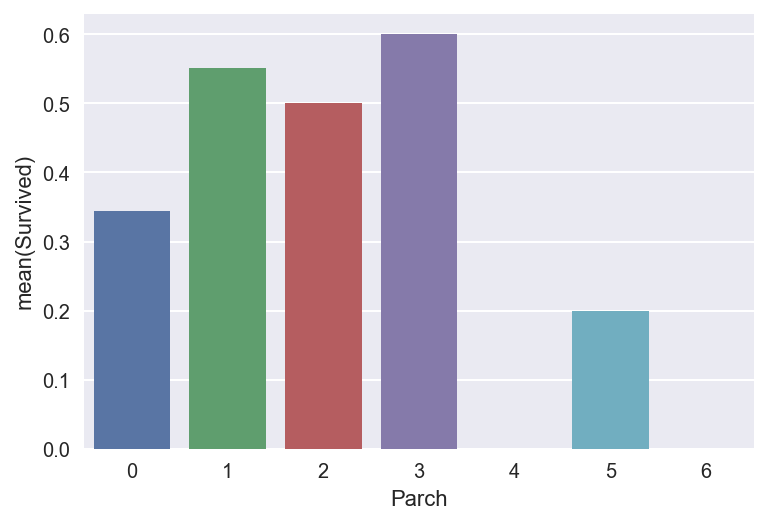

In [132]:
sns.barplot(data=titanic,x="Parch",y="Survived",ci=None,palette="deep")

- 除去多父母子女数(>4)、多姊妹配偶数(>4)的乘客，有父母子女或配偶姊妹的乘客幸存率更高，这可能源于亲人之间相互让出生存机会，相互帮助，以及信仰的力量

In [133]:
titanic.pivot_table(values="Survived",index="SibSp",columns="Pclass",aggfunc="count")

Pclass,1,2,3
SibSp,,,
0,137.0,120.0,351.0
1,71.0,55.0,83.0
2,5.0,8.0,15.0
3,3.0,1.0,12.0
4,NaN,NaN,18.0
5,NaN,NaN,5.0
8,NaN,NaN,7.0


In [134]:
titanic.pivot_table(values="Survived",index="Parch",columns="Pclass",aggfunc="count")

Pclass,1,2,3
Parch,,,
0,163.0,134.0,381.0
1,31.0,32.0,55.0
2,21.0,16.0,43.0
3,NaN,2.0,3.0
4,1.0,NaN,3.0
5,NaN,NaN,5.0
6,NaN,NaN,1.0


- 无配偶姊妹的乘客最多；3等仓位乘客最多
- 有1个配偶姊妹的乘客数量第二，各等仓位分布较均匀
- 3等仓位拖家带口的乘客相对于1、2等仓位较多--底层民众更多地是关联关系上船，可能是去同一个地方打工，谋生，安家等等，也可能是3等仓位基础人数大（需结合分组总人数比例来看）

In [138]:
titanic.pivot_table(values="Survived",index="Parch",columns=["Pclass","Embarked"],aggfunc="count")

Pclass       1                2                 3             
Embarked     C    Q     S     C    Q      S     C     Q      S
Parch                                                         
0         64.0  2.0  95.0  12.0  3.0  119.0  47.0  64.0  270.0
1         15.0  NaN  16.0   1.0  NaN   31.0  14.0   6.0   35.0
2          6.0  NaN  15.0   4.0  NaN   12.0   4.0   1.0   38.0
3          NaN  NaN   NaN   NaN  NaN    2.0   1.0   NaN    2.0
4          NaN  NaN   1.0   NaN  NaN    NaN   NaN   NaN    3.0
5          NaN  NaN   NaN   NaN  NaN    NaN   NaN   1.0    4.0
6          NaN  NaN   NaN   NaN  NaN    NaN   NaN   NaN    1.0

- 3等仓位乘客主要在S码头登船
- Q码头登船的3等仓位乘客最多
- 拖家带口的乘客主要在S码头登船，主要为3等仓乘客

### 相关性分析

In [19]:
correlation=titanic[["Survived","Pclass","Sex","Age","Embarked","SibSp","Parch"]].corr()
correlation

,Survived,Pclass,Age,SibSp,Parch
Survived,1.000000,-0.338481,-0.073296,-0.035322,0.081629
Pclass,-0.338481,1.000000,-0.338056,0.083081,0.018443
Age,-0.073296,-0.338056,1.000000,-0.236376,-0.176038
SibSp,-0.035322,0.083081,-0.236376,1.000000,0.414838
Parch,0.081629,0.018443,-0.176038,0.414838,1.000000


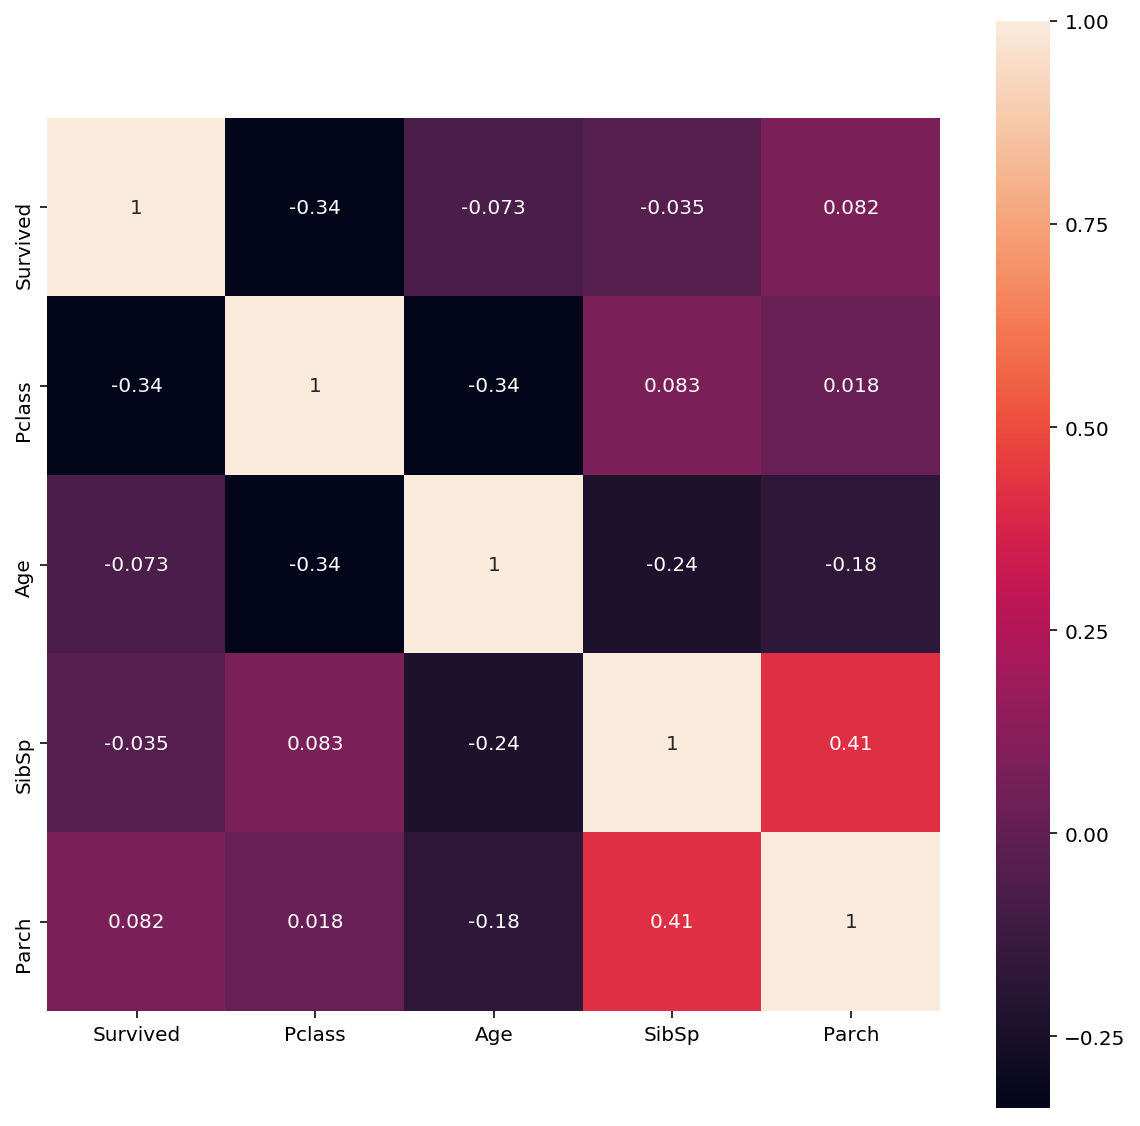

In [24]:
fig=plt.figure(figsize=(10,10))
sns.heatmap(correlation,vmax=1,square=True,annot=True)